In [1]:
#import potrzebnych bibliotek
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#funkcja obliczająca odległość między dwoma wierzchołkami z matematycznym zaokrągleniem
def distance(x1,x2,y1,y2):
    return np.floor(np.sqrt((x1-x2)**2+(y1-y2)**2)+0.5)

In [3]:
#wczytanie pierwszej instancji (kroA100)

instance = pd.read_csv('kroA100.tsp', sep=' ', names=['node', 'x', 'y'], skiprows=6, skipfooter=1,
                      engine='python')
kroA100 = []

for index1, row1 in instance.iterrows():
    tmp = []
    for index2, row2 in instance.iterrows():
        if (index1==index2):
            tmp.append(0)
        else:
            tmp.append(distance(row1['x'],row2['x'],row1['y'],row2['y']))
    kroA100.append(tmp)

np.array(kroA100)

array([[   0., 1693., 2252., ...,  783., 1468., 2643.],
       [1693.,    0., 1708., ..., 1911., 3156., 1831.],
       [2252., 1708.,    0., ..., 1786., 3315.,  454.],
       ...,
       [ 783., 1911., 1786., ...,    0., 1535., 2228.],
       [1468., 3156., 3315., ..., 1535.,    0., 3760.],
       [2643., 1831.,  454., ..., 2228., 3760.,    0.]])

In [4]:
#wczytanie drugiej instancji (kroB100)

instance2 = pd.read_csv('kroB100.tsp', sep=' ', names=['node', 'x', 'y'], skiprows=6, skipfooter=1,
                      engine='python')

kroB100 = []

for index1, row1 in instance2.iterrows():
    tmp = []
    for index2, row2 in instance2.iterrows():
        if (index1==index2):
            tmp.append(0)
        else:
            tmp.append(distance(row1['x'],row2['x'],row1['y'],row2['y']))
    kroB100.append(tmp)

np.array(kroB100)

array([[   0., 2607.,  549., ...,  229.,  618., 1249.],
       [2607.,    0., 3154., ..., 2621., 3075., 2661.],
       [ 549., 3154.,    0., ...,  571.,  403., 1499.],
       ...,
       [ 229., 2621.,  571., ...,    0.,  480., 1475.],
       [ 618., 3075.,  403., ...,  480.,    0., 1796.],
       [1249., 2661., 1499., ..., 1475., 1796.,    0.]])

In [5]:
#funkcja obliczająca całkowitą długość cyklu
def distance_sum(cycle,matrix):
    distance = 0
    for i in range(len(cycle)):
        if i==len(cycle)-1:
            distance+=matrix[cycle[i]][cycle[0]]
        else:
            distance+=matrix[cycle[i]][cycle[i+1]]
    return distance

In [6]:
#algorytm zachłanny inspirowany metodą najbliższego sąsiada
def nearest_neighbour(matrix, cycle, remaining):
    min_distance = matrix[cycle[0]][remaining[0]]
    min_node = remaining[0]
    node_cycle = cycle[0]
    for node_to_add in remaining:
        for node_in_cycle in cycle:
            if matrix[node_to_add][node_in_cycle] < min_distance:
                min_distance = matrix[node_to_add][node_in_cycle]
                min_node = node_to_add
                node_cycle = node_in_cycle
    return min_node, node_cycle

In [7]:
#algorytm zachłanny inspirowany metodą rozbudowy cyklu
def greedy_cycle(matrix, cycle, remaining):
    min_distance = 999999999
    index = -1
    min_node = cycle[0]
    for node_to_add in remaining:
        for i in range (len(cycle)):
            if i!=len(cycle)-1:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[i+1]][node_to_add] - matrix[cycle[i]][cycle[i+1]]
            else:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[0]][node_to_add] - matrix[cycle[i]][cycle[0]]
            if tmp_distance < min_distance:
                min_distance = tmp_distance
                min_node = node_to_add
                index = i
    return min_node, index

In [8]:
#funkcja zwracająca listę wierzchołków, dla których najlepsze miejsce wstawienia to miejsce w cyklu o podanym indeksie
def nodes_with_best_given_index(matrix,cycle,remaining,given_index):
    result_nodes = []
    for node_to_add in remaining:
        best1 = 9999999999998
        best2 = 9999999999999
        index = -1
        for i in range (len(cycle)):
            if i!=len(cycle)-1:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[i+1]][node_to_add] - matrix[cycle[i]][cycle[i+1]]
            else:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[0]][node_to_add] - matrix[cycle[i]][cycle[0]]
            if tmp_distance < best2:
                if tmp_distance < best1:
                    best2 = best1
                    best1 = tmp_distance
                    index = i
                else:
                    best2 = tmp_distance
        if index == given_index:
            result_nodes.append([node_to_add,best1,best2])
    return result_nodes

In [9]:
#obliczony największy 2-żal dla listy wierzchołków
def calculate_regret(list_nodes):
    list_nodes = np.array(list_nodes)
    difference = list_nodes[:,2]-list_nodes[:,1]
    best_result_index = np.argmax(difference)
    return int(list_nodes[best_result_index][0])

In [10]:
#algorytm typu regret heuristics (z żalem) na bazie algorytmu inspirowanego metodą rozbudowy cyklu – stosujemy 2-regret
def greedy_regret(matrix, cycle, remaining):
    best_node_to_add, best_index = greedy_cycle(matrix, cycle, remaining)
    nodes_on_the_same_position = nodes_with_best_given_index(matrix, cycle, remaining, best_index)
    return calculate_regret(nodes_on_the_same_position), best_index

In [11]:
#losowanie pierwszego wierzchołka startowego - drugi wyznaczany jest jako najdalszy od pierwszego
def get_start_nodes(matrix):
    first_start=rd.randint(0, 99)
    second_start=np.argmax(matrix[first_start])
    return first_start,second_start

In [12]:
#utworzenie dwóch list (cyklów) i dodanie wierzchołków startowych oraz utworzenie listy z pozostałymi wierzchołkami
def create_cycles(first_start, second_start):
    cycle1=[]
    cycle2=[]
    remaining = list(range(100))
    remaining.remove(first_start)
    remaining.remove(second_start)
    cycle1.append(first_start)
    cycle2.append(second_start)
    return cycle1, cycle2, remaining

In [13]:
# wyznaczanie wyniku dla algorytmu nearest_neighbour

def calculate_nearest_neighbour(matrix, cycle1, cycle2, remaining):
    while(remaining):
        node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle1, remaining)
        index = cycle1.index(node_in_cycle)
        cycle1.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
        if not remaining:
            break
        node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle2, remaining)
        index = cycle2.index(node_in_cycle)
        cycle2.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
    return([distance_sum(cycle1,matrix)+distance_sum(cycle2,matrix), cycle1, cycle2])

In [14]:
# wyznaczanie wyniku dla algorytmu greedy_cycle - drugi wierzchołek cyklu jest dodawany za pomocą metody nearest_neighbour

def calculate_greedy_cycle(matrix, cycle1, cycle2, remaining):
    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle1, remaining)
    index = cycle1.index(node_in_cycle)
    cycle1.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle2, remaining)
    index = cycle2.index(node_in_cycle)
    cycle2.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    while (remaining):
        node_to_add, index = greedy_cycle(matrix, cycle1, remaining)
        cycle1.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
        if not remaining:
             break
        node_to_add, index = greedy_cycle(matrix, cycle2, remaining)
        cycle2.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
    return([distance_sum(cycle1,matrix)+distance_sum(cycle2,matrix), cycle1, cycle2])

In [15]:
# wyznaczanie wyniku dla algorytmu greedy_regret - drugi wierzchołek cyklu jest dodawany za pomocą metody nearest_neighbour
# a trzeci za pomocą greedy_cycle

def calculate_greedy_regret(matrix, cycle1, cycle2, remaining):
    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle1, remaining)
    index = cycle1.index(node_in_cycle)
    cycle1.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle2, remaining)
    index = cycle2.index(node_in_cycle)
    cycle2.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, index = greedy_cycle(matrix, cycle1, remaining)
    cycle1.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, index = greedy_cycle(matrix, cycle2, remaining)
    cycle2.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    while (remaining):
        node_to_add, index = greedy_regret(matrix, cycle1, remaining)
        index = int(index)
        cycle1.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
        if not remaining:
             break
        node_to_add, index = greedy_regret(matrix, cycle2, remaining)
        index = int(index)
        cycle2.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
    return([distance_sum(cycle1,matrix)+distance_sum(cycle2,matrix), cycle1, cycle2])

In [16]:
results_kroA100 = [[],[],[]]
results_kroB100 = [[],[],[]]
iterate = 0
while (iterate<100):
    #obliczanie dla kroA100
    first_start, second_start = get_start_nodes(kroA100)
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroA100[0].append(calculate_nearest_neighbour(kroA100, cycle1, cycle2, remaining))
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroA100[1].append(calculate_greedy_cycle(kroA100, cycle1, cycle2, remaining))
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroA100[2].append(calculate_greedy_regret(kroA100, cycle1, cycle2, remaining))
    
    #obliczanie dla kroB100
    first_start, second_start = get_start_nodes(kroB100)
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroB100[0].append(calculate_nearest_neighbour(kroB100, cycle1, cycle2, remaining))
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroB100[1].append(calculate_greedy_cycle(kroB100, cycle1, cycle2, remaining))
    
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroB100[2].append(calculate_greedy_regret(kroB100, cycle1, cycle2, remaining))
    iterate+=1

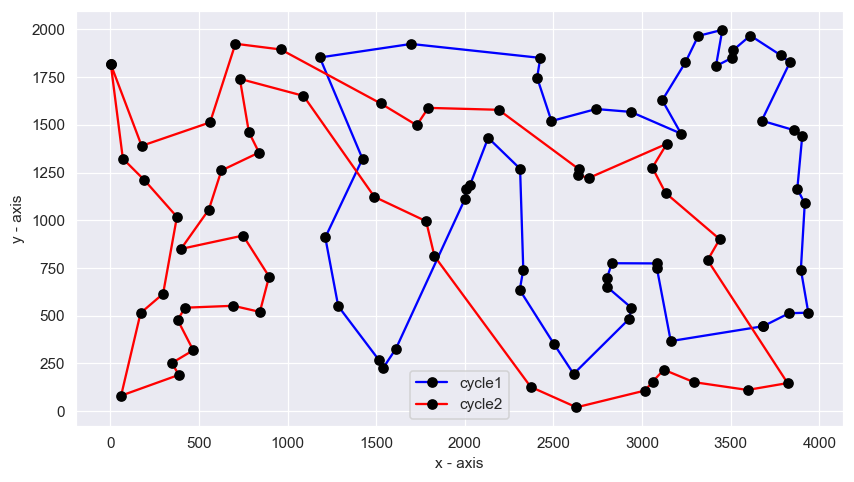

In [28]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
best_result = np.argmin(results_kroB100[2], axis=0)
cycle1 = results_kroB100[2][best_result[0]][1]
cycle2 = results_kroB100[2][best_result[0]][2]


cycle1.append(cycle1[0])
cycle2.append(cycle2[0])

coordinate_x_cycle1 = []
coordinate_y_cycle1 = []
coordinate_x_cycle2 = []
coordinate_y_cycle2 = []
for node in cycle1:
    coordinate_x_cycle1.append(instance2.loc[node]['x'])
    coordinate_y_cycle1.append(instance2.loc[node]['y'])
for node in cycle2:
    coordinate_x_cycle2.append(instance2.loc[node]['x'])
    coordinate_y_cycle2.append(instance2.loc[node]['y'])
    
# plotting the line 1 points
plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [41]:
best = np.min(results_kroB100[2], axis=0)
print(best[0])
worst = np.max(results_kroB100[2], axis=0)
print(worst[0])
#mean = np.mean(np.array(results_kroA100), axis=0)
mean = []
for x in results_kroB100[2]:
    mean.append(x[0])
print(np.mean(mean))

26927.0
32230.0
30438.94
